# Ambient Noise Signal Processing Detector
__Contributors:__ Bilguun Bulgan, Coraline Sun, Caitlyn Liu, Isaac Castillo
<br>__Instructors:__ Ryan Kastner, Perry Naughton, Tahiya Salam
<br>__Description:__ This project is a part of the UC San Diego Early Scholars Research Program (ERSP). This detector was built particularly to detect the signals of the snapping shrimp of the La Jolla shore waters. The detector takes in a sound file, calcuates the frequencies with the Fourier Transformation, then returns "a snap" as a unit. The snap should have comprehensive attributes of a sound wave, including the direct arrival of the snap, and its corresponding reflected waves. 

In [4]:
import numpy as np
from scipy.io.wavfile import read
from scipy import signal, arange
from scipy.signal import hilbert, find_peaks_cwt
import matplotlib.pyplot as plt
import matplotlib.axes as matax
import matplotlib.mlab as mlab
import sys
from math import exp
import operator


In [5]:
#samplingFrequency: 
#read() returns sample rate of wave file as sampFreq (int) and data read from wav file (numpy array)
sampFreq, sound = read('wav1.wav');


In [6]:
#taking 5 seconds of sample from 15s - 20sec in file 
#interval have 100 frames towards left and 400 frames towards right
initTime = 0;    # the start time
duration = 300;     # duration of time period start at initTime
leftOffset = 100;  # how many frames we should expand the interval to the left
rightOffset = 200; # how many frames we should expand ther interval to the right
windowSize = 0.01; # the size of the window we will ignore after capture the frame above threshold

#start and end will hold the indeces in the sound sample array
start = sampFreq * initTime;
end = start + sampFreq * duration;

#s1 holds the spliced soundsample array
s1 = sound[start:end];

In [7]:
#preparing timeArray for plotting. The plot will have x-axis in seconds (and not in indeces)
timeArray = np.arange(0, end-start, 1)
timeArray = timeArray / sampFreq

## This displayes the amplitude graph (with the points of interested noted in dots) and the spectrogram


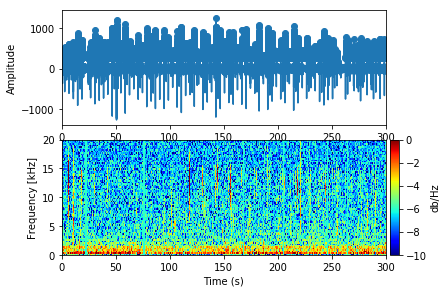

In [8]:
fig = plt.figure()
#fig, axes = plt.subplots(nrows=2, ncols=1)
ax1 = fig.add_axes( [0.12, 0.55, 0.75, 0.4] )
ax2 = fig.add_axes( [0.12, 0.1, 0.75, 0.4] )
ax3 = fig.add_axes( [0.88, 0.1, 0.02, 0.4] )
    
#--- Figure 1. ---#
ax1.plot(timeArray, s1)
ax1.set_ylabel('Amplitude')
ax1.set_xlim(0, duration)
ax1.margins(x=0)

#--- Figure 2. ---#
f, t, Sxx = signal.spectrogram(s1, sampFreq, nperseg=256)
Sxx[Sxx==0] = exp(-6)
im = ax2.pcolormesh(t, f/1000, np.log(Sxx), cmap='jet' )

#setting up the amplitude threshold
ampThreshold = np.std(s1) * 10

#the boolean array about whether at each indexthe amplitude is above threshold or not
aboveThres = s1 > ampThreshold 

#puts a mark at every point above the threshold
ax1.scatter(timeArray[aboveThres],s1[aboveThres])

ax2.set_ylabel('Frequency [kHz]')
ax2.set_ylim(0,20)
ax2.set_xlim(0, duration);
ax2.set_xlabel('Time (s)')
ax2.margins(x=0)
im.set_clim(-10, 0)

mappable = im
cb = plt.colorbar(mappable = mappable, cax = ax3)
cb.set_label('db/Hz')

plt.show();

#### Since 

In [9]:
#pick out the time when the amplitude is above threshold
timeArray[aboveThres]
snaps = [];
snapIndex = [];

# current = the first time frame has amplitude above threshold
# snaps = the time where each loud signal above threshold
# snapIndex = the time frame indices of each loud signal above threshold
current = timeArray[aboveThres][0] 
snaps.append(current)
snapIndex.append(current * sampFreq)

# set a 0.01sec time window that slides across the current array
# so that we only collect one time data for each loud signal
for time in timeArray[aboveThres]: 
    
    if (time > current + windowSize ):
        snapIndex.append(time * sampFreq)
        snaps.append(time)
        current = time
        

In [10]:
def getFrequencies(signal):
    length = len(signal) # length of the signal
    #k = arange(length)
    #T = length/sampFreq
    #frq = k/T # two sides frequency range
    #frq = frq[range(np.int(length/2))] # one side frequency range

    frequencies = np.fft.fft(signal)/length # fft computing and normalization
    frequencies = frequencies[range(np.int(length/2))]
    
    return abs(frequencies)

In [11]:
def plotFrequencies(signal, ax):
    length = len(signal) # length of the signal
    k = arange(length)
    T = length/sampFreq
    frq = k/T # two sides frequency range
    frq = frq[range(np.int(length/2))] # one side frequency range
 
    
    ax.plot(frq, getFrequencies(signal),'r') # plotting the spectrum

    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('|Y(freq)|')

In [12]:
def plotAmplitude(signal, time, ax):
    
    ax.plot(time, signal)
    ax.set_xlabel('sample frames')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(front, back)
    ax.margins(x=0)

In [13]:
def plotEnvelope(signal, time, ax):
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
   
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * sampFreq)

    ax.plot(time, signal, label='signal')
    ax.plot(time, amplitude_envelope, label='envelope')
    ax.set_xlabel("time in seconds")
    ax.legend()
    
    markPeaks(amplitude_envelope, time, ax)

In [37]:
def markPeaks(enveloped_signal, time, ax):
    peak_indexes = find_peaks_cwt(enveloped_signal, arange(1, 20), noise_perc = 50);
    tuple_array=[]
    largestPeaks = []
    #print("x")
    #print(peak_indexes)
    #print("y") 
    #print(enveloped_signal[peak_indexes])
 
    for i in range(0, len(peak_indexes)):
        data = (peak_indexes[i],enveloped_signal[peak_indexes[i]])
        tuple_array.append(data)
    
    tuple_array.sort(key = operator.itemgetter(1), reverse=True)

    selected = []
    count = 0
    index = tuple_array[0][0]
    selected.append(tuple_array[0])
    for tuple_element in tuple_array:
        if (tuple_element[0] > index):
            selected.append(tuple_element)
            index = tuple_element[0]
            count = count + 1
        if (count == 2):
            break;

    index_list = [x[0] for x in selected]
    amplitude_list = [x[1] for x in selected]
    ax.scatter(index_list+time[0], amplitude_list, c ='r')
    
    return selected


In [15]:
 def filterNLargestPeaks(n, peak_indexes, enveloped_signal):
    highestPeaks = enveloped_signal[peak_indexes]
    return peak_indexes[np.argsort(highestPeaks)[-n:]]

In [16]:
def getRatio(signal):
    frequencies = getFrequencies(signal)
    ratio = sum(frequencies[34:68] * 100/sum(frequencies))
    return ratio;
    

In [17]:
def classify(signal):
    
    ratio = getRatio(signal)
    if (ratio > 70):
        return "Ping"
    
    elif (ratio < 50):
        return "Snap"
    else:
        return "Undefined"

In [18]:
# make a histogram
sound_filtered = []
for i in s1:
    sound_filtered.append(abs(i))


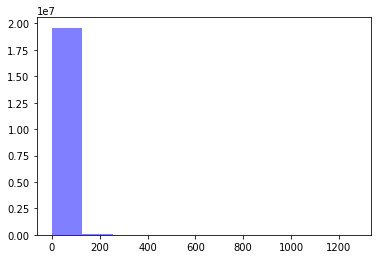

In [19]:
num_bins = 10
n, bins, patches = plt.hist(sound_filtered, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [36]:
timeInterval = []  # the time array for each sound clip
signalInterval = []
freq = []

for i in range(0, len(snapIndex)):
    front= int(snapIndex[i]-leftOffset)
    back=  int(snapIndex[i]+rightOffset)
    
    signal = s1[front:back]
    time = timeArray[front:back] * sampFreq;
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    
    #--- Figure 1. amplitude - time ---#
    #plotAmplitude(signal, time, axes[0])
    plotEnvelope(signal, time, axes[0])

    
    #--- Figure 2. Y(freq) - freq ---#
    plotFrequencies(signal, axes[1])
    
    classification = classify(signal)
    fig.suptitle(classification)
    
    fname = ""
    
    if (classification == "Snap"):
        fname ='../Plots/Snaps/%f-%f.png'% (front/sampFreq, back/sampFreq)
    elif (classification == "Ping"):
        fname ='../Plots/Pings/%f-%f.png'% (front/sampFreq, back/sampFreq)
    else:
        fname ='../Plots/undefined/%f-%f.png'% (front/sampFreq, back/sampFreq)
        
    
    #plt.show()
     
    #save image
    fig.savefig(fname)
    
    plt.close()
    
    
   

In [ ]:
#Making Scatter plots
